# Prerequisites

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet50

In [2]:
data_dir = "../data"
val_img_dir = f"{data_dir}/val_images"

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
f"Using device: {device}"

'Using device: cuda'

# Dataset class

In [3]:
class HWSet(Dataset):
    """Dataset class for the Husky vs. Wolf dataset."""

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.val_img_dir = f"{self.data_dir}/val_images"

        all_labels = np.loadtxt(
            f"{self.data_dir}/ILSVRC2012_validation_ground_truth.txt"
        ).astype(int)
        all_img_files = os.listdir(self.val_img_dir)

        self.class_indices = []
        for idx, name in ((3, "siberian husky"), (205, "grey wolf")):
            self.class_indices.append(np.where(all_labels == idx)[0])

        self.labels = []
        for label, indices in enumerate(self.class_indices):
            self.labels = self.labels + indices.size * [label]
        self.labels = np.array(self.labels)

        self.imgs = [
            all_img_files[idx] for indices in self.class_indices for idx in indices
        ]

    def __len__(self):
        return self.labels.size

    def __getitem__(self, item):
        img = Image.open(f"{val_img_dir}/{self.imgs[item]}")

        if self.transform is not None:
            img = self.transform(img)

        return (img, self.labels[item])

## Transforms

In [12]:
transform = transforms.Compose(
    [
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
normalize_inv = transforms.Compose([
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)),
    transforms.Normalize(mean=(-0.485, -0.456, -0.406), std=(1.0, 1.0, 1.0))
]) # For visualization purposes.

## Dataset

In [13]:
dset = HWSet(data_dir, transform=transform)
len(dset)

100

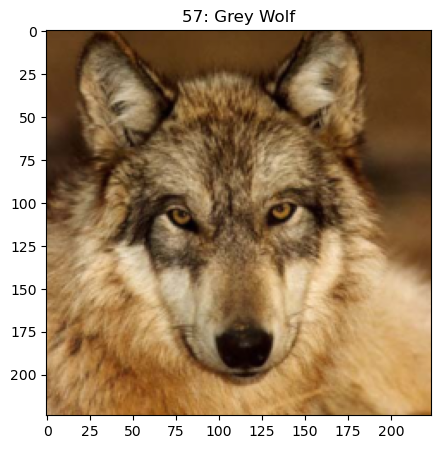

In [15]:
class_legend = ("Siberian Husky", "Grey Wolf")

item = 57
img, label = dset[item]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(np.moveaxis(normalize_inv(img).numpy(), 0, -1))
ax.set_title(f"{item}: {class_legend[label]}");

# Load model

In [7]:
# model = resnet50(weights="DEFAULT")
# model.to(device);